In [1]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dt
# import gresearch_crypto
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_columns', None)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
EPOCHS = 10
DEBUG = True
N_ASSETS = 14
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10

In [5]:
def reduce_mem_usage(df):
    """ 
        iterate through all the columns of a pandas.dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                ## control integer
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                ## control float(np.finfo(np.float16).precision)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    next
        print(f'{col_type}->{df[col].dtype.name}')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## Data Loading

In [6]:
train = dt.fread('train.jay').to_pandas()
train = train.sort_values('timestamp').set_index("timestamp")
test = dt.fread('example_test.jay').to_pandas()
sample_prediction_df = dt.fread('example_sample_submission.jay').to_pandas()
assets = dt.fread('asset_details.jay').to_pandas()
assets_order = dt.fread('supplemental_train.jay').to_pandas().Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(assets_order))
print("Loaded all data!")

Loaded all data!


# Feature Engineering

In [7]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
    df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']
    df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    df_feat['shadow3'] = df_feat['upper_Shadow'] / df_feat['Volume']
    df_feat['shadow5'] = df_feat['lower_Shadow'] / df_feat['Volume']
    df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
    df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
    df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
    df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    df_feat['UPS'] = df_feat['UPS']
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    df_feat['LOS'] = df_feat['LOS']
    df_feat['RNG'] = ((df_feat['High'] - df_feat['Low']) / df_feat['VWAP'])
    df_feat['RNG'] = df_feat['RNG']
    df_feat['MOV'] = ((df_feat['Close'] - df_feat['Open']) / df_feat['VWAP'])
    df_feat['MOV'] = df_feat['MOV']
    df_feat['CLS'] = ((df_feat['Close'] - df_feat['VWAP']) / df_feat['VWAP'])
    df_feat['CLS'] = df_feat['CLS']
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    df_feat['LOGVOL'] = df_feat['LOGVOL']
    df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
    df_feat['LOGCNT'] = df_feat['LOGCNT']
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"]
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"]
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"]
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    if row: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df_feat['high2mean'] = df_feat['High'] / mean_price
    df_feat['low2mean'] = df_feat['Low'] / mean_price
    df_feat['high2median'] = df_feat['High'] / median_price
    df_feat['low2median'] = df_feat['Low'] / median_price
    df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    return df_feat

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']] = train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df
train = get_features(train)
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'groups']]

(24236806, 9)


In [ ]:
class GTJA_191:
    def __init__(self, price, asset_id, start_timestamp, end_timestamp):
        price = price[price['Asset_ID']==asset_id]
        price = price[price['timestamp']>=start_timestamp]
        price = price[price['timestamp']<=end_timestamp]
        price = price.set_index(['timestamp'],drop=False)
        self.price     = price
        self.values    = price.values
        self.timestamp = price['timestamp']
        self.id        = price['Asset_ID']
        self.open      = price['Open']
        self.close     = price['Close']
        self.low       = price['Low']
        self.high      = price['High']
        self.volume    = price['Volume']
        self.vwap      = price['VWAP']
        self.amount    = price['Volume']*price['VWAP']
        self.target    = price['Target']
        
    def ret(self):
        res = self.price
        res.insert(10, 'Amount', self.amount, allow_duplicates=False)
        res.insert(11, 'alpha_002', self.alpha_002(), allow_duplicates=False)
        res.insert(12, 'alpha_011', self.alpha_011(), allow_duplicates=False)
        res.insert(13, 'alpha_013', self.alpha_013(), allow_duplicates=False)
        res.insert(14, 'alpha_014', self.alpha_014(), allow_duplicates=False)
        res.insert(15, 'alpha_015', self.alpha_015(), allow_duplicates=False)
        res.insert(16, 'alpha_018', self.alpha_018(), allow_duplicates=False)
        res.insert(17, 'alpha_020', self.alpha_020(), allow_duplicates=False)
        res.insert(18, 'alpha_024', self.alpha_024(), allow_duplicates=False)
        res.insert(19, 'alpha_029', self.alpha_029(), allow_duplicates=False)
        res.insert(20, 'alpha_031', self.alpha_031(), allow_duplicates=False)
        res.insert(21, 'alpha_034', self.alpha_034(), allow_duplicates=False)
        res.insert(22, 'alpha_065', self.alpha_065(), allow_duplicates=False)
        res.insert(23, 'alpha_066', self.alpha_066(), allow_duplicates=False)
        res.insert(24, 'alpha_070', self.alpha_070(), allow_duplicates=False)
        res.insert(25, 'alpha_129', self.alpha_129(), allow_duplicates=False)
        res.insert(26, 'alpha_132', self.alpha_132(), allow_duplicates=False)
        res.insert(27, 'alpha_178', self.alpha_178(), allow_duplicates=False)
        return res
    
    def alpha_002(self):
        alpha = ((self.close-self.low)-(self.high-self.close))/((self.high-self.low)).diff()
        return alpha
    
    def alpha_011(self):
        alpha = ((((self.close-self.low)-(self.high-self.close))/(self.high-self.low))*self.volume).rolling(6).sum()
        return alpha
    
    def alpha_013(self):
#         (((HIGH * LOW)^0.5) - VWAP)
        alpha = (self.high*self.low)**0.5-self.vwap
        return alpha
    
    def alpha_014(self):
#         CLOSE-DELAY(CLOSE,5)
        alpha = self.close - self.close.shift(5)
        return alpha
    
    def alpha_015(self):
#         OPEN/DELAY(CLOSE,1)-1
        alpha = self.open/self.close.shift() - 1
        return alpha
    
    def alpha_018(self):
#         CLOSE/DELAY(CLOSE,5)
        alpha = self.close/self.close.shift(5)
        return alpha
        
    def alpha_020(self):
#         (CLOSE-DELAY(CLOSE,6))/DELAY(CLOSE,6)*100
        alpha = (self.close-self.close.shift(6))/self.close.shift(6)*100
        return alpha
    
    def alpha_024(self):
        result = self.close - self.close.shift(5)
        result = result.ewm(alpha = 1.0/5).mean()
        alpha = result
        return alpha
    
    def alpha_029(self):
        delay = self.close.shift(6)
        alpha = (self.close-delay)*self.volume/delay
        return alpha
    
    def alpha_031(self):
        rolling_mean = self.close.rolling(12).mean()
        alpha = (self.close-rolling_mean)*100/rolling_mean
        return alpha
    
    def alpha_034(self):
        alpha = self.close.rolling(12).mean()/self.close
        return alpha
        
    def alpha_065(self):
        part1 = self.close.rolling(6)
        alpha = part1.mean()/self.close.shift()
        return alpha_070
    
    def alpha_066(self):
        part1=self.close.rolling(6)
        alpha=(self.close.shift()-part1.mean())/part1.mean()
        return alpha
    
    def alpha_070(self):
        alpha = self.amount.rolling(6).std()
        return alpha
    
    def alpha_129(self):
        data = self.close.diff()
        data[data >= 0] = 0
        data = abs(data)
        alpha = data.rolling(12).sum()
        return alpha
    
    def alpha_132(self):
        alpha = self.amount.rolling(20).mean()
        return alpha
    
    def alpha_178(self):
        alpha = ((self.close-self.close.shift())/self.close.shift()*self.volume).shift()
        return alpha

## Building a Time Series Model

In [8]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape

(27397440, 46)

In [9]:
# Matching records and marking generated rows as 'non-real'
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)

In [10]:
# Features values for 'non-real' rows are set to zeros
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.

In [11]:
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
train.head(20)
gc.collect()

Memory usage of dataframe is 5747.69 MB
int64->int8
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
float32->float32
int64->int32
int64->int8
int64->int8
Memory usage after optimization is: 5094.54 MB
Decreased by 11.4%


0

In [12]:
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = train.columns.drop(['Asset_ID', 'Target', 'group_num', 'is_real'])
train = train[features]
train = train.values
train = train.reshape(-1, N_ASSETS, train.shape[-1])

In [13]:
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])
        return np.array(batch_x), np.array(batch_y)

In [14]:
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

In [15]:
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 14, 45)
Target shape: (1024, 14)


## Training

In [16]:
def MaxCorrelation(y_true,y_pred): return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
def Correlation(y_true,y_pred): return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def get_squence_model(x):
    x = layers.LSTM(units=32, return_sequences=True)(x)
    return x

def get_model(n_assets = 14):
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))
    branch_outputs = []
    for i in range(n_assets):
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) # Slicing the ith asset:
        a = layers.Masking(mask_value = 0., )(a)
        a = get_squence_model(a)
        a = layers.GlobalAvgPool1D()(a)
        branch_outputs.append(a)
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units = 128)(x)
    out = layers.Dense(units = n_assets)(x)
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = masked_cosine, metrics=[Correlation])
    return model
    
model = get_model()
model.summary()

2021-12-10 11:32:00.378792: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 11:32:02.837452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2021-12-10 11:32:02.838705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9658 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2021-12-10 11:32:02.839814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/de

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 14, 45)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15, 45)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15, 45)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 15, 45)       0           input_1[0][0]                    
______________________________________________________________________________________________

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'spread',
       'mean_trade', 'log_price_change', 'upper_Shadow', 'lower_Shadow',
       'high_div_low', 'trade', 'gtrade', 'shadow1', 'shadow3', 'shadow5',
       'diff1', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'UPS', 'LOS',
       'RNG', 'MOV', 'CLS', 'LOGVOL', 'LOGCNT', 'Close/Open', 'Close-Open',
       'High-Low', 'High/Low', 'Mean', 'High/Mean', 'Low/Mean', 'Volume/Count',
       'high2mean', 'low2mean', 'high2median', 'low2median', 'volume2count',
       'asset_order'],
      dtype='object')


2021-12-10 11:32:40.318120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2021-12-10 11:33:12.205876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


1720/1720 [==============================] - 224s 108ms/step - loss: -0.0020 - Correlation: 0.0202 - val_loss: -0.0024 - val_Correlation: 0.0215
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009919992, shape=(), dtype=float32).
1720/1720 [==============================] - 169s 98ms/step - loss: -0.0050 - Correlation: 0.0238 - val_loss: -0.0032 - val_Correlation: 0.0254
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009840622, shape=(), dtype=float32).
1720/1720 [==============================] - 171s 99ms/step - loss: -0.0054 - Correlation: 0.0235 - val_loss: -0.0037 - val_Correlation: 0.0253
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00097618887, shape=(), dtype=float32).
1720/1720 [==============================] - 171s 99ms/step - loss: -0.0066 - Correlation: 0.0248 - val_loss: -0.0027 - val_Correlation: 0.0253
Epoch 5/10

Epoch 00005: LearningRateScheduler setting l

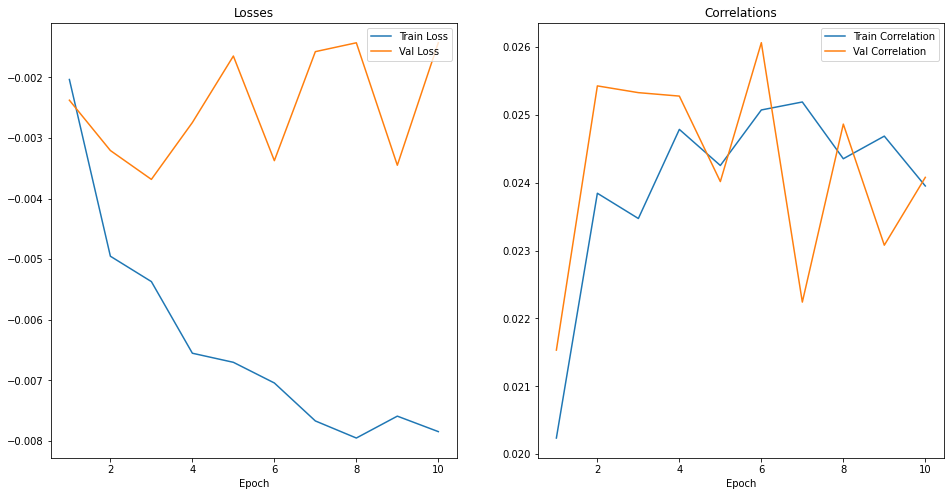

In [17]:
print(features)

tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
history = model.fit(train_generator, validation_data = (val_generator), epochs = EPOCHS, callbacks = [lr, estop])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
histories = pd.DataFrame(history.history)
epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']
ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')
ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
fig.show()
gc.collect()

# The correlation coefficients by asset for the validation data
predictions = model.predict(val_generator)
print('Asset:    Corr. coef.')
print('---------------------')
for i in range(N_ASSETS):
    # drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    y_pred = np.squeeze(predictions[:, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}")

In [18]:
sup = dt.fread('supplemental_train.jay').to_pandas()[:WINDOW_SIZE * (N_ASSETS)]
placeholder = get_features(sup)
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order)
test_sample = np.array(placeholder[features])
test_sample = test_sample.reshape(-1, (N_ASSETS), test_sample.shape[-1])
test_sample = np.expand_dims(test_sample, axis=0)

In [19]:
example = dt.fread('example_test.jay').to_pandas()[:WINDOW_SIZE - 1]
example['asset_order'] = example.Asset_ID.map(assets_order) 
example = example[['Asset_ID','asset_order']]

## Submit To Kaggle

In [ ]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = get_features(test_df)
    test_data = test_df.merge(example, how='outer', on='Asset_ID').sort_values('asset_order')
    test = np.array(test_data[features].fillna(0))
    test = test.reshape(-1, 1, N_ASSETS, test.shape[-1])
    test_sample = np.hstack([test_sample, test])[:,-1 * WINDOW_SIZE:]
    y_pred = model.predict(test_sample).squeeze().reshape(-1, 1).squeeze()
    test_data['Target'] = y_pred
    for _, row in test_df.iterrows():
        try: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = test_data.loc[test_data['row_id'] == row['row_id'], 'Target'].item()
        except: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = 0
    env.predict(sample_prediction_df)